In [1]:
# libraries
import numpy as np
import cv2
from matplotlib import pyplot as plt

In [2]:
# functions

def show_images(images, titles=None):
    for idx, im in enumerate(images):
        plt.imshow(im)
        if titles is not None: plt.title(titles[idx])
        plt.show()

# 3) Hough

### A) point to sinusoid


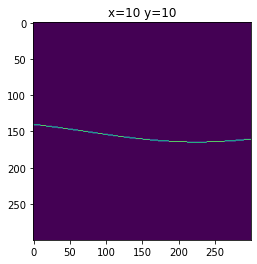

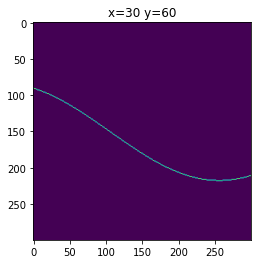

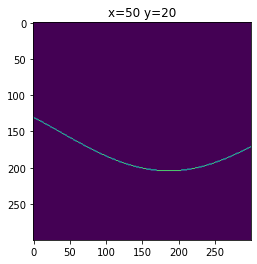

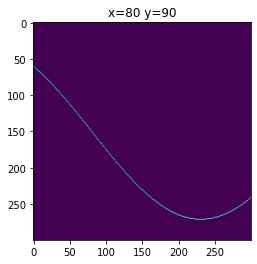

In [3]:
from math import cos, sin, pi


def convert_pints_to_Hough_space(points, rho_size, theta_size):
    hough_spaces = []

    rho_origin = - theta_size // 2  # rho = 0 is in the middle of field
    bin_size = pi / theta_size

    for p in points:
        hough_space = np.zeros((rho_size, theta_size))
        for theta in range(hough_space.shape[1]):
            theta_rad = theta * bin_size - pi / 2  # we start on pi/2
            rho = p[0] * cos(theta_rad) + p[1] * sin(theta_rad)
            rho = rho + rho_origin
            hough_space[int(rho), theta] += 1
        hough_spaces.append(hough_space)
    return hough_spaces


points = [(10, 10), (30, 60), (50, 20), (80, 90)]
hough_spaces = convert_pints_to_Hough_space(points, 300, 300)
show_images(hough_spaces, titles=[f'x={p[0]} y={p[1]}' for p in points])

### B) show point on image in hough space

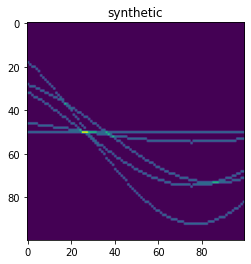

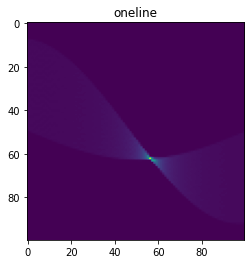

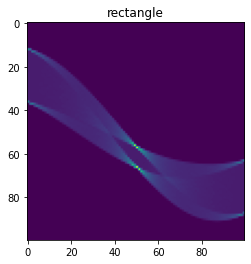

In [4]:
from math import cos, sin, radians, pi, sqrt
from itertools import product


def points_to_hough_space(I, theta_size, rho_size):
    acc = np.zeros((rho_size, theta_size))

    theta_binsize = pi / theta_size
    theta_origin = -pi / 2
    src_diagonal = sqrt(I.shape[0] ** 2 + I.shape[1] ** 2)
    rho_binsize = (2 * src_diagonal) / rho_size
    rho_origin = - src_diagonal

    important_pixels = [(x, y) for x, y in product(range(I.shape[0]), range(I.shape[1])) if I[x, y] != 0]
    for x, y in important_pixels:
        for theta in range(acc.shape[1]):
            theta_rad = theta * theta_binsize + theta_origin  # we start on pi/2
            rho = x * cos(theta_rad) + y * sin(theta_rad)
            rho = int((rho - rho_origin) / rho_binsize)
            if rho < acc.shape[0] and theta < acc.shape[1]:
                acc[int(rho), theta] += 1
    return acc


def synthetic():
    synthetic = np.zeros((100, 100))
    synthetic[10, 10] = 1
    synthetic[30, 60] = 1
    synthetic[80, 90] = 1
    synthetic[0, 0] = 1
    synthetic[50, 50] = 1
    return synthetic


hough_size = 100
#images
images = [synthetic(), cv2.imread('images/oneline.png'), cv2.imread('images/rectangle.png')]
syn_hough_space = points_to_hough_space(synthetic(), hough_size, hough_size)
oneline_hough = points_to_hough_space(cv2.Canny(cv2.imread('images/oneline.png'), 100, 100), hough_size, hough_size)
rectangle_hough = points_to_hough_space(cv2.Canny(cv2.imread('images/rectangle.png'), 100, 100), hough_size, hough_size)

im_hough_spaces = [points_to_hough_space(images[0], hough_size, hough_size)] + [
    points_to_hough_space(cv2.Canny(I, 100, 100), hough_size, hough_size) for I in images[1:]]
#im_hough_spaces = [syn_hough_space, oneline_hough, rectangle_hough]
im_titles = ['synthetic', 'oneline', 'rectangle']

show_images(im_hough_spaces, im_titles)

### C) non maxima supression

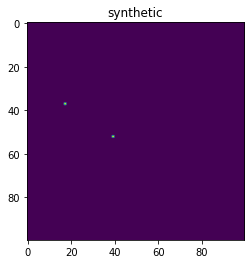

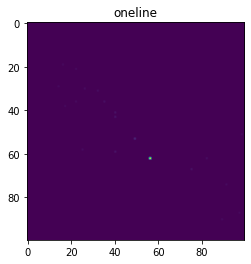

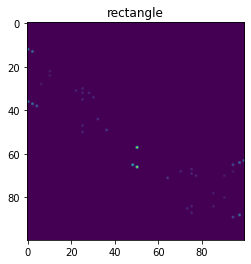

In [5]:
import scipy.ndimage as ndimage
from itertools import product


def nonmaxima_suppression_box(src):
    src = np.copy(src)
    neighborhood = np.array([[1, 1, 1],
                             [1, 0, 1],
                             [1, 1, 1]])
    neighborhood_max = ndimage.generic_filter(src, lambda x: max(x), footprint=neighborhood, mode='constant', cval=0)
    # return max value of neighborhood for each pixel
    coordinates = product(range(src.shape[0]), range(src.shape[1]))
    for coor, nei_max in zip(coordinates, neighborhood_max.reshape(-1)):
        if src[coor] <= nei_max: src[coor] = 0
    return src


im_local_maxima = [nonmaxima_suppression_box(src) for src in im_hough_spaces]
show_images(im_local_maxima, im_titles)

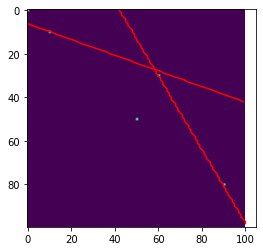

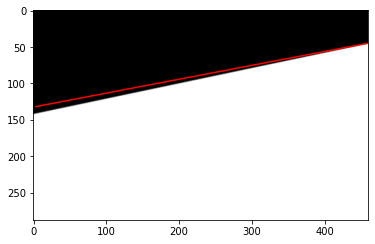

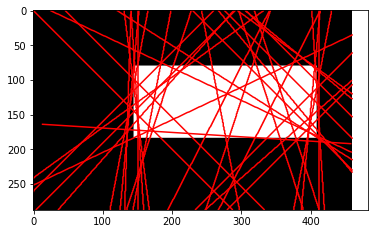

In [6]:
from itertools import product


def get_parameters(I, threshold):
    parameters = [(x, y) for x, y in product(range(I.shape[0]), range(I.shape[1])) if I[x, y] >= threshold]
    return parameters


parameters = [get_parameters(I, threshold) for I, threshold in zip(im_local_maxima, [1, 50, 22])]


#print(parameters[0])

def convert_params_to_line_param(params, rho_size, theta_size):
    rho, theta = params
    theta_binsize = pi / theta_size
    theta_origin = -pi / 2
    src_diagonal = sqrt(I.shape[0] ** 2 + I.shape[1] ** 2)
    rho_binsize = (2 * src_diagonal) / rho_size
    rho_origin = - src_diagonal

    converted_rho = (rho * rho_binsize) + rho_origin
    converted_theta = theta * theta_binsize + theta_origin
    return converted_rho, converted_theta


def draw_line(I, rho, theta):
    a = np.cos(theta)
    b = np.sin(theta)
    xs = []
    ys = []
    for x in range(I.shape[0]):
        y = int((-x * a + rho) / b)
        if 0 <= y <= I.shape[1]:
            xs.append(x)
            ys.append(y)
    plt.plot(ys, xs, 'r')


def draw_lines(I, parameters, rho_size, theta_size):
    plt.imshow(I)
    converted_params = list(map(lambda x: convert_params_to_line_param(x, rho_size, theta_size), parameters))
    for rho, theta in converted_params:
        draw_line(I, rho, theta)
    plt.show()


for I, param in zip(images, parameters):
    draw_lines(I, param, hough_size, hough_size)

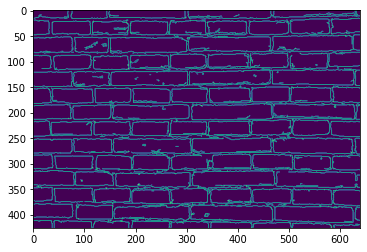

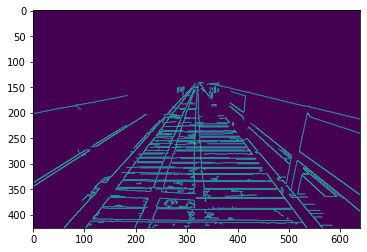

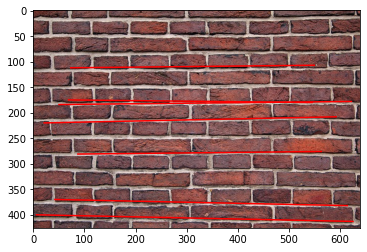

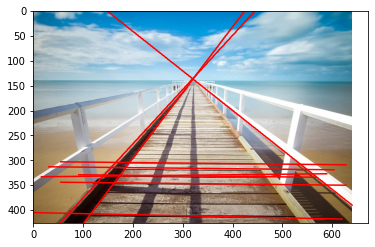

In [7]:
def get_best_parameters(I, param_count=10):
    parameters = [(x, y, I[x, y]) for x, y in product(range(I.shape[0]), range(I.shape[1])) if I[x, y] > 0]
    parameters = [(x, y) for x, y, s in sorted(parameters, key=lambda x: x[2], reverse=True)]
    return parameters[:param_count + 1]


def hough_find_lines(I, theta_size, rho_size):
    hough_space = points_to_hough_space(I, theta_size, rho_size)
    maxima_pixels = nonmaxima_suppression_box(hough_space)
    parameters = get_best_parameters(maxima_pixels, param_count=10)
    return parameters


def find_edges(I, threshold):
    I = np.copy(I)
    I = cv2.cvtColor(I, cv2.COLOR_BGR2GRAY)
    I = cv2.Canny(I, threshold[0], threshold[1])
    plt.imshow(I)
    plt.show()
    return I


Is = [cv2.cvtColor(cv2.imread(f'images/{im_name}'), cv2.COLOR_BGR2RGB) for im_name in ['bricks.jpg', 'pier.jpg']]
edges = [find_edges(I, threshold) for I, threshold in zip(Is, [(500, 200), (400, 150)])]
hough_sizes = [(300, 300), (300,300)]
parameters = [hough_find_lines(I, sizes[0], sizes[1]) for I, sizes in zip(edges, hough_sizes)]
for I, params, sizes in zip(Is, parameters, hough_sizes):
    draw_lines(I, params, sizes[0], sizes[1])